In [1]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

In [2]:
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df = pd.concat([df, temp_df], axis=1)
    df.index.names = ['time']
    df.index = pd.to_datetime(df.index, unit='s')
    df = df.dropna().pct_change().dropna()

In [3]:
def MV_criterion(weights, df):
    """
    Ountput:
        optimización del criterio (media-varianza) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        df(type ndarray numpy): Retornos de los activos
    """
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25/100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(df, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    # Calcular el criterio
    criterion = (Wbar**(1-Lambda)/(1+Lambda)+
                 Wbar**(-Lambda)*W*mean-
                 Lambda/2*Wbar**(-1-Lambda)*
                 W**2*std**2
                 )
    criterion = -criterion
    return criterion

In [4]:
def SK_criterion(weights, df):
    """
    Ountput:
        optimización del criterio (media-varianza sesgo kurtosis) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        df(type ndarray numpy): Retornos de los activos
    """
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(df, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media, la volatilidad, el sesgo y la curtosis de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    skewness = skew(portfolio_return, 0)
    kurt = kurtosis(portfolio_return, 0)
    # Calcular el criterio
    criterion = Wbar**(1 - Lambda) / (1 + Lambda) + Wbar**(-Lambda)\
        * W * mean - Lambda / 2 * Wbar**(-1 - Lambda) * W**2 * std**2\
        + Lambda * (Lambda + 1) / (6) * Wbar**(-2 - Lambda) * W**3 * skewness\
        - Lambda * (Lambda + 1) * (Lambda + 2) / (24) * Wbar**(-3 - Lambda)\
        * W**4 * kurt
    criterion = -criterion
    return criterion

In [5]:
def SR_criterion(weight, df):
    """
    Ountput:
        optimización del criterio (ratio de Sharpe) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        df(type ndarray numpy): Retornos de los activos
    """
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(df, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std=np.std(portfolio_return, axis=0)
    # Calcular el opuesto al ratio de Sharpe
    sharpe = mean / std
    sharpe=-sharpe
    return sharpe

In [6]:
def SOR_criterion(weight, df):
    """
    Ountput:
        optimización del criterio (ratio de Sortino) de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        df(type ndarray numpy): Retornos de los activos
    """
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(df, np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return[portfolio_return < 0], axis=0)
    # Calcular el opuesto al ratio de Sortino
    Sortino = mean / std
    Sortino = -Sortino
    return Sortino

In [7]:
split = int(0.7*len(df))
train_set = df.iloc[:split, :]
test_set = df.iloc[split:, :]
# Encontrar el número de activos
n = df.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución de los problemas de optimización
res_MV = minimize(MV_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SK = minimize(SK_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SR = minimize(SR_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
res_SOR = minimize(SOR_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
# ResultadoS
X_MV = res_MV.x
X_SK = res_SK.x
X_SR = res_SR.x
X_SOR = res_SOR.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.2493686277381828
            Iterations: 36
            Function evaluations: 3636
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.3782333439079144
            Iterations: 13
            Function evaluations: 1317
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0685801792307431
            Iterations: 26
            Function evaluations: 2629
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.17020669383590345
            Iterations: 26
            Function evaluations: 2662
            Gradient evaluations: 26


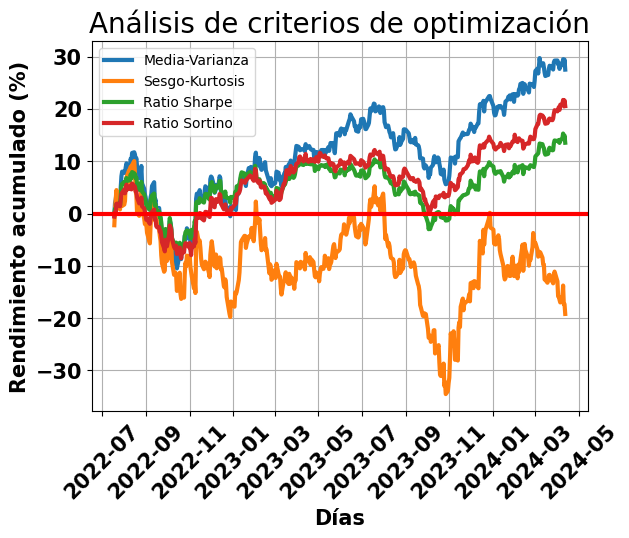

In [8]:
# Calcular la retabilidad acumulada de la cartera
portfolio_return_MV = np.multiply(test_set, np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)
portfolio_return_SK = np.multiply(test_set, np.transpose(X_SK))
portfolio_return_SK = portfolio_return_SK.sum(axis=1)
portfolio_return_SR = np.multiply(test_set, np.transpose(X_SR))
portfolio_return_SR = portfolio_return_SR.sum(axis=1)
portfolio_return_SOR = np.multiply(test_set, np.transpose(X_SOR))
portfolio_return_SOR = portfolio_return_SOR.sum(axis=1)
portfolio_strategies = pd.concat(
   [
      portfolio_return_MV,
      portfolio_return_SK,
      portfolio_return_SR,
      portfolio_return_SOR
   ], axis=1)
portfolio_strategies.columns = columns=[
   "Media-Varianza", 
   "Sesgo-Kurtosis", 
   "Ratio Sharpe",
   "Ratio Sortino"]

# Representar el CM
for column in portfolio_strategies.columns:
    plt.plot(np.cumsum(portfolio_strategies[column]) * 100, linewidth=3, label=column)

plt.ylabel("Rendimiento acumulado (%)", size=15, fontweight='bold')
plt.xlabel("Días", size=15, fontweight='bold')
plt.xticks(rotation=45) 
plt.xticks(size=15, fontweight='bold')
plt.yticks(size=15, fontweight='bold')
plt.title("Análisis de criterios de optimización", size=20)
plt.axhline(0, color='r', linewidth=3)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()